In [29]:
!pip install tqdm

In [30]:
!pip install progress

In [44]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
import sklearn.linear_model as sl
import scipy.stats as st
import time
from tqdm import *
from progress.bar import Bar

In [2]:
url1 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/x.quad.0.txt'
url2 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/x.quad.70.txt'
url3 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h0_0.rs35.txt'
url4 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h1_0.rs35.txt'
url5 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h2_0.rs35.txt'
url6 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h3_0.rs35.txt'
url7 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h4_0.rs35.txt'
url8 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h0_70.rs35.txt'
url9 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h1_70.rs35.txt'
url10 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h2_70.rs35.txt'
url11 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h3_70.rs35.txt'
url12 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h4_70.rs35.txt'

# 0 - 20: indepedent standard normal
# 21 - 41: squares
# 42 - 251: pairwise interactions
x1 = pd.read_csv(url1, header = None, delim_whitespace = True)
x2 = pd.read_csv(url2, header = None, delim_whitespace = True)

# response
y1_h0 = pd.read_csv(url3, delim_whitespace = True)
y1_h1 = pd.read_csv(url4, delim_whitespace = True)
y1_h2 = pd.read_csv(url5, delim_whitespace = True)
y1_h3 = pd.read_csv(url6, delim_whitespace = True)
y1_h4 = pd.read_csv(url7, delim_whitespace = True)

y2_h0 = pd.read_csv(url8, delim_whitespace = True)
y2_h1 = pd.read_csv(url9, delim_whitespace = True)
y2_h2 = pd.read_csv(url10, delim_whitespace = True)
y2_h3 = pd.read_csv(url11, delim_whitespace = True)
y2_h4 = pd.read_csv(url12, delim_whitespace = True)

In [3]:
def reg_subset(x,y):
    """performs regression subset selection"""
    lm = sl.LinearRegression()
    
    in_ = []
    out_ = list(range(x.shape[1]))
    rss = [sum((y-np.mean(y))**2)]
    (n,m) = x.shape
    
    if(m>=n):
        ml = n-5
    else:
        ml = m   
    vm = np.array(range(ml))

    for pi in range(x.shape[1]):
        rss_find = []
        for i in out_:
            fit_X = pd.DataFrame(x.ix[:, in_ + [i]])
            lm.fit(fit_X, y)
            pred = lm.predict(fit_X)
            rss_find.append(sum((pred-y)**2))
        min_rss = np.min(rss_find)
        min_var = out_[rss_find.index(min_rss)]
        rss.append(min_rss)
        in_.append(min_var)
        del out_[rss_find.index(min_rss)]
        in_var = [x.columns[i] for i in in_]
    rss = np.array(rss)
    pv_org = 1 - st.f.cdf((rss[vm] - rss[vm+1])*(n-(vm+2))/rss[vm+1],
                     1,n-(vm+2))
    return (np.array(in_),np.array(in_var),rss, pv_org)

In [4]:
def gic(rss, m, n, z):
    """gic gives model size including intercept of min BIC model"""
    t1 = z*np.arange(2, m + 3) + n*np.log(rss/n) + n + 2*n*np.log(np.sqrt(2*np.pi))
    t2 = np.argmin(t1) + 1
    return(t2)

In [5]:
def bic_sim(x, y):
    """chooses from FAS using minimum BIC"""
    lm = sl.LinearRegression()
    (n,m) = x.shape
    out_x = reg_subset(x, y)
    rss = out_x[2]
    vorder = out_x[0]
    if m > n:
        rss = rss[0:60]
        m = 60
    # model size including intercept
    bic = gic(rss, m, n, np.log(n))
    if bic > 1:
        index = vorder[0:bic - 1]
        x = x.ix[:,index]
        x_ind = index
    else:
        x_ind = 0
    if bic == 1:
        intercept = pd.DataFrame(np.ones(n))
        mod = lm.fit(intercept, y)  
        fitted = lm.predict(intercept)
        residual = sum((y - fitted)**2)
        df_residual = n - (bic - 1) - 1
    else:
        mod = lm.fit(x, y)
        fitted = lm.predict(x)
        residual = sum((y - fitted)**2)
        df_residual = n - (bic - 1) - 1
    return dict({'fitted': fitted, 'residual': residual, 'df_residual': df_residual, 'size': bic - 1, 'index': x_ind})

In [25]:
def fsr_fast_pv(pv_orig, m, gam0 = 0.05, digits = 4, printout = True, plot = True):
    """Fast FSR based on summary p-values from forward selection"""
    m1 = len(pv_orig)
    pvm = np.zeros(m1)

    # create monotone p-values
    for i in range(0, m1):
        pvm[i] = np.max(pv_orig[0:(i+1)])
    alpha = np.concatenate([np.array([0]), pvm])
    ng = len(alpha)
    
    # calculate model size
    S = np.zeros(ng)
    for j in range(1, ng):
        S[j] = sum(pvm <= alpha[j])
        
    # calculate gamma hat
    ghat = (m - S)*alpha/(1 + S)
    
    # add additional points to make jumps
    alpha2 = alpha[1:ng] - 0.0000001
    ghat2 = (m - S[0:(ng - 1)])*alpha2/(1 + S[0:(ng - 1)])
    zp = pd.DataFrame({'a': np.concatenate([alpha, alpha2]), 'g': np.concatenate([ghat, ghat2])})
    zp.sort_values(by =['a', 'g'], ascending = [True, False], inplace = True)
    
    # largest gamma hat and index
    gamma_max = np.argmax(zp['g'])
    
    alpha_max = zp['a'][gamma_max]

    # model size with ghat just below gam0
    ind = np.logical_and(ghat <= gam0, alpha <= alpha_max)*1
    Sind = S[np.max(np.where(ind > 0))]
    
    # calculate alpha_F
    alpha_fast = (1 + Sind)*gam0/(m - Sind)
    
    # size of model no intercept
    size1 = sum(pvm <= alpha_fast)
    
    # generate plot
    if plot==True:
        plt.plot(zp['a'], zp['g'], marker = 'o', markersize = 6)
        plt.ylabel('Estimated Gamma')
        plt.xlabel('Alpha')
        pass

    df1 = pd.DataFrame({'pval': pv_orig, 'pvmax': pvm, 'ghigh': ghat2, 'glow': ghat[1:ng]}, columns = ['pval', 'pvmax', 'ghigh', 'glow'])
    df2 = pd.DataFrame({'m1': m1, 'm': m, 'gam0': gam0, 'size': size1, 'alphamax': alpha_max, 'alpha_fast': alpha_fast}, columns = ['m1', 'm', 'gam0', 'size', 'alphamax', 'alpha_fast'], index=[0])
    if printout == True:
        print(df1,df2)
    return(np.round(df1, digits), np.round(df2, digits), ghat)

In [26]:
def fsr_fast(x, y, gam0 = 0.05,digits = 4,printout = False, plot = False):
    """
    Estimated alpha for forward selection using Fast FSR (no simulation)
    """
    lm = sl.LinearRegression()
    
    x = pd.DataFrame(x)
    y = pd.DataFrame(y)
    y.columns = ["y"]
    cols = np.array(range(x.shape[1]))
    colnames = map(lambda x: "x" + str(x), cols)
    x.columns = colnames
    df = pd.concat([x,y], axis = 1)
    x = df.ix[:,:-1]
    y = df.ix[:,-1]
    
    # forward selection
    out = reg_subset(x,y)
    #print(out)
    pv_orig = out[3]
    m = len(pv_orig)
    n = x.shape[0]
    
    # model selection using fast fsr
    dfs = fsr_fast_pv(pv_orig, m, printout = printout, plot = plot)
    
    # get the variables should be included
    size = int(dfs[1].ix[0,3])
    var_idx = out[0][:size]
    
    # fit model
    if len(var_idx)==0:
        intercept = pd.DataFrame(np.ones(x.shape[0]))
        lm.fit(intercept, y)
        fitted = lm.predict(intercept)
    else:
        x = x.ix[:,var_idx]
        lm.fit(x,y)
        fitted = lm.predict(x)
    residual = sum((y-fitted)**2)
    df_residual = n - size - 1
    return {'fitted':fitted, 'residual':residual, 'df_residual':df_residual, 
            'size':size, 'index': var_idx}

In [36]:
def lasso_fit(x, y):
    
    #Define the alpha values to test
    alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]
    
    #Initialize the dataframe to store coefficients
    col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,x.shape[1]+1)]
    ind = [str(alpha_lasso[i]) for i in range(0,10)]
    coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)
    
    for i in range(10):
        ls = sl.Lasso(alpha=alpha_lasso[i],normalize=True, max_iter=1e5)
        ls.fit(x,y)
        y_pred = ls.predict(x)
        #Return the result in pre-defined format
        rss = sum((y_pred-y)**2)
        ret = [rss]
        ret.extend([ls.intercept_])
        ret.extend(ls.coef_)
        coef_matrix_lasso.iloc[i,] = ret
    
    exist = np.sum(coef_matrix_lasso.ix[:,2:]==0, axis = 1)!=x.shape[1]
    if(sum(exist)==0):
        size = 0
        lm = sl.LinearRegression()
        intercept = pd.DataFrame(np.ones(x.shape[0]))
        lm.fit(intercept, y)
        fitted = lm.predict(intercept)
    else:
        alpha = pd.to_numeric(coef_matrix_lasso.index[exist][-1])
        ls = sl.Lasso(alpha=alpha,normalize=True, max_iter=1e5)
        ls.fit(x,y)
        fitted = ls.predict(x)
        index = np.array(range(len(ls.coef_)))[ls.coef_!=0]
        size = len(index)
        
    # get residuals
    residual = sum((y-fitted)**2)
    df_residual = x.shape[0] - size - 1
    
    return {'fitted':fitted, 'residual':residual, 'df_residual':df_residual, 
            'size':size, 'index': index}

In [6]:
# simulation
x1_matrix = x1.ix[:,0:20]
x2_matrix = x2.ix[:,0:20]
hbeta = np.zeros((5, 14))
hbeta[0,:] = np.repeat(-1, 14)
hbeta[1,:] = np.concatenate([np.array([6, 13]), np.repeat(-1, 12)])
hbeta[2,:] = np.concatenate([np.array([5, 6, 7, 12, 13, 14]), np.repeat(-1, 8)])
hbeta[3,:] = np.concatenate([np.array([4, 5, 6, 7, 8, 11, 12, 13, 14, 15]), np.repeat(-1, 4)])
hbeta[4,:] = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

In [20]:
def simulation(x, y, model):
    res = np.zeros((5, 14))
    me_out = np.zeros((100, 4))
    me_out1_21 = np.zeros((100, 4, 5))
    me_out2_21 = np.zeros((100, 4, 5))
    jac = np.zeros(100)
    data = y
    for m in range(5):
        hdata = data[m]
        hdata_y = np.array(hdata.ix[:,2]).reshape([100, 150])
        mu = hdata.ix[0:149,1]                                     # true means
        beta = hbeta[m,:]
        
        for i in tqdm(range(100)):
            out_bic = model(x, hdata_y[i,:])
            size = out_bic['size']                                 # number of fitted x's
            correct = len(np.intersect1d(out_bic['index'], beta))  # number correct
            false = size - correct                                 # number false
            me_out[i, 0] = np.mean((out_bic['fitted'] - mu)**2)    # model error
            me_out[i, 1] = size
            me_out[i, 2] = false
            me_out[i, 3] = out_bic['residual']/out_bic['df_residual']
        
        me_out1_21[:,:,1] = np.round(me_out, 4)
        model_size = sum(beta != -1)                               # true model size
     
        for i in range(100):
            if me_out[i, 2] + model_size > 0:
                jac[i] = (me_out[i, 1] - me_out[i, 2])/(me_out[i, 2] + model_size)
            else:
                jac[i] = 1
        res[m, 0] = 0                                              # rho
        res[m, 1] = m                                              # model h0, h1
        res[m, 2] = np.mean(me_out[:,1])                           # model size
        res[m, 3] = np.std(me_out[:,1]/10)                         # se of the mean
        res[m, 4] = np.mean(me_out[:,0])                           # me
        res[m, 5] = np.std(me_out[:,0])/10
        res[m, 6] = np.mean(me_out[:,2]/(1 + me_out[:,1]))         # fsr
        res[m, 7] = np.std(me_out[:,2]/(1 + me_out[:,1]))/10
        res[m, 8] = np.mean(me_out[:,3])                           # mse of selected model
        res[m, 9] = np.std(me_out[:,3])/10
        if model_size > 0:
            csr = (me_out[:,1] - me_out[:,2])/model_size
        else:
            csr = np.ones(100)
        res[m, 10] = np.mean(csr)
        res[m, 11] = np.std(csr)/10
        res[m, 12] = np.mean(jac)
        res[m, 13] = np.std(jac)/10
    return np.round(pd.DataFrame({'rho': res[:,0], 'H': res[:,1], 'size': res[:,2], 'me': res[:,4], 
                     'fsr_mr': res[:,6], 'mse': res[:,8], 'csr': res[:,10], 'jac': res[:,12],
                     'se_size': res[:,3], 'se_me': res[:,5], 'se_fsr': res[:,7], 'se_mse': res[:,9],
                     'se_csr': res[:,11], 'se_jac': res[:,13]}), 3)

In [21]:
res_bic1 = simulation(x1_matrix, [y1_h0, y1_h1, y1_h2, y1_h3, y1_h4], bic_sim)

100%|██████████| 100/100 [00:31<00:00,  4.13it/s]


In [22]:
res_bic1

,H,csr,fsr_mr,jac,me,mse,rho,se_csr,se_fsr,se_jac,se_me,se_mse,se_size,size
0,0.0,1.000,0.243,0.560,0.033,0.960,0.0,0.000,0.028,0.050,0.004,0.012,0.088,0.62
1,1.0,1.000,0.132,0.829,0.045,0.989,0.0,0.000,0.015,0.020,0.003,0.013,0.072,2.58
2,2.0,0.572,0.091,0.532,0.088,0.975,0.0,0.013,0.012,0.014,0.005,0.011,0.106,3.95
3,3.0,0.449,0.065,0.431,0.123,1.005,0.0,0.010,0.009,0.010,0.006,0.011,0.128,4.94
4,4.0,0.419,0.036,0.411,0.153,1.016,0.0,0.009,0.007,0.009,0.006,0.013,0.139,6.15


In [23]:
res_bic2 = simulation(x2_matrix, [y2_h0, y2_h1, y2_h2, y2_h3, y2_h4], bic_sim)

100%|██████████| 100/100 [00:26<00:00,  4.02it/s]


In [24]:
res_bic2

,H,csr,fsr_mr,jac,me,mse,rho,se_csr,se_fsr,se_jac,se_me,se_mse,se_size,size
0,0.0,1.000,0.208,0.640,0.029,0.995,0.0,0.000,0.028,0.048,0.003,0.010,0.084,0.55
1,1.0,0.990,0.109,0.854,0.044,0.991,0.0,0.007,0.015,0.020,0.004,0.013,0.068,2.45
2,2.0,0.402,0.128,0.373,0.080,0.971,0.0,0.010,0.014,0.011,0.004,0.011,0.073,2.98
3,3.0,0.277,0.067,0.270,0.109,0.999,0.0,0.008,0.011,0.008,0.004,0.012,0.091,3.09
4,4.0,0.241,0.055,0.237,0.112,0.997,0.0,0.007,0.010,0.007,0.004,0.012,0.102,3.66


In [31]:
res_fsr1 = simulation(x1_matrix, [y1_h0, y1_h1, y1_h2, y1_h3, y1_h4], fsr_fast)

100%|██████████| 100/100 [00:28<00:00,  3.61it/s]


In [33]:
res_fsr1

,H,csr,fsr_mr,jac,me,mse,rho,se_csr,se_fsr,se_jac,se_me,se_mse,se_size,size
0,0.0,1.000,0.062,0.880,0.015,0.975,0.0,0.000,0.017,0.032,0.003,0.011,0.042,0.14
1,1.0,1.000,0.048,0.937,0.031,1.000,0.0,0.000,0.011,0.014,0.003,0.013,0.050,2.21
2,2.0,0.537,0.055,0.512,0.089,0.988,0.0,0.014,0.010,0.014,0.005,0.011,0.115,3.54
3,3.0,0.424,0.050,0.408,0.132,1.016,0.0,0.012,0.009,0.011,0.007,0.012,0.164,4.61
4,4.0,0.409,0.033,0.401,0.155,1.021,0.0,0.010,0.006,0.010,0.006,0.013,0.161,5.99


In [34]:
res_fsr2 = simulation(x2_matrix, [y2_h0, y2_h1, y2_h2, y2_h3, y2_h4], fsr_fast)

100%|██████████| 100/100 [00:30<00:00,  3.22it/s]


In [35]:
res_fsr2

,H,csr,fsr_mr,jac,me,mse,rho,se_csr,se_fsr,se_jac,se_me,se_mse,se_size,size
0,0.0,1.000,0.047,0.910,0.011,1.009,0.0,0.000,0.015,0.029,0.002,0.010,0.033,0.10
1,1.0,0.985,0.053,0.921,0.036,0.999,0.0,0.009,0.011,0.017,0.004,0.013,0.050,2.19
2,2.0,0.363,0.070,0.348,0.075,0.987,0.0,0.007,0.012,0.007,0.004,0.011,0.066,2.48
3,3.0,0.244,0.041,0.240,0.114,1.014,0.0,0.007,0.009,0.007,0.004,0.012,0.078,2.62
4,4.0,0.210,0.038,0.208,0.124,1.014,0.0,0.007,0.009,0.007,0.004,0.013,0.099,3.12


In [37]:
res_lasso1 = simulation(x1_matrix, [y1_h0, y1_h1, y1_h2, y1_h3, y1_h4], lasso_fit)

100%|██████████| 100/100 [00:01<00:00, 78.80it/s]


In [38]:
res_lasso1

,H,csr,fsr_mr,jac,me,mse,rho,se_csr,se_fsr,se_jac,se_me,se_mse,se_size,size
0,0.0,1.000,0.690,0.000,0.016,0.973,0.0,0.000,0.014,0.000,0.002,0.011,0.379,3.45
1,1.0,1.000,0.422,0.489,0.064,1.035,0.0,0.000,0.016,0.017,0.003,0.013,0.143,4.55
2,2.0,0.697,0.269,0.531,0.105,1.039,0.0,0.012,0.012,0.013,0.004,0.011,0.132,6.22
3,3.0,0.580,0.175,0.506,0.139,1.088,0.0,0.011,0.012,0.011,0.005,0.011,0.157,7.38
4,4.0,0.537,0.083,0.507,0.178,1.126,0.0,0.010,0.008,0.009,0.005,0.013,0.168,8.37


In [39]:
res_lasso2 = simulation(x2_matrix, [y2_h0, y2_h1, y2_h2, y2_h3, y2_h4], lasso_fit)

100%|██████████| 100/100 [00:01<00:00, 58.92it/s]


In [40]:
res_lasso2

,H,csr,fsr_mr,jac,me,mse,rho,se_csr,se_fsr,se_jac,se_me,se_mse,se_size,size
0,0.0,1.000,0.675,0.000,0.017,1.009,0.0,0.000,0.014,0.000,0.002,0.010,0.479,3.79
1,1.0,1.000,0.420,0.490,0.058,1.035,0.0,0.000,0.016,0.017,0.004,0.013,0.142,4.53
2,2.0,0.662,0.271,0.509,0.064,1.006,0.0,0.015,0.016,0.016,0.003,0.011,0.167,6.06
3,3.0,0.578,0.167,0.510,0.077,1.028,0.0,0.011,0.012,0.011,0.003,0.011,0.151,7.26
4,4.0,0.500,0.107,0.467,0.079,1.035,0.0,0.010,0.009,0.009,0.003,0.012,0.167,8.02


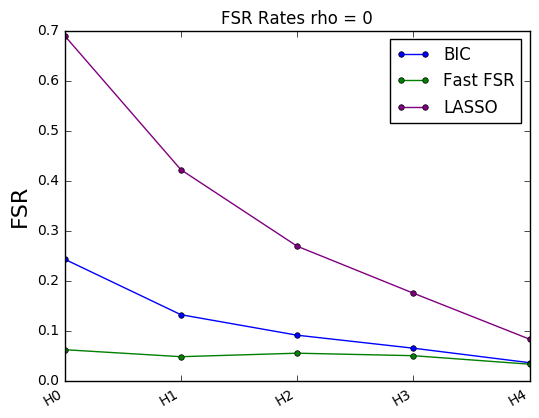

In [74]:
xlabel = [1, 2, 3, 4, 5]
xlabel_name = ['H0', 'H1', 'H2', 'H3', 'H4']

fig, ax = plt.subplots(figsize = (6, 5)) 
fig.autofmt_xdate()
plt.plot(xlabel, res_bic1['fsr_mr'], marker = 'o', markersize = 4, 
         color = 'blue', linestyle = 'solid',
         label = 'BIC')

plt.plot(xlabel, res_fsr1['fsr_mr'], marker = 'o', markersize = 4, 
         color = 'green', linestyle = 'solid',
         label = 'Fast FSR')

plt.plot(xlabel, res_lasso1['fsr_mr'], marker = 'o', markersize = 4, 
         color = 'purple', linestyle = 'solid',
         label = 'LASSO')

plt.legend(loc='upper right')
ax.set_ylabel('FSR', fontsize = 16)
ax.set_title('FSR Rates rho = 0')
plt.xticks(xlabel, xlabel_name)
pass 

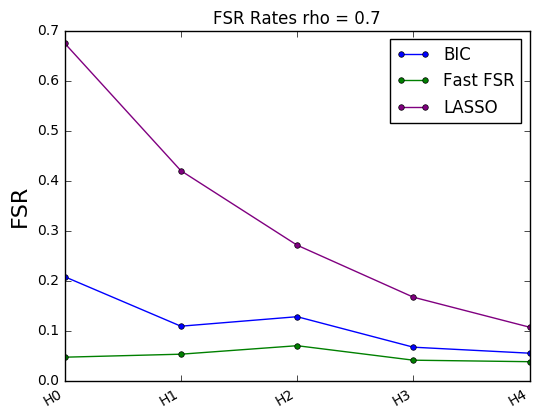

In [73]:
xlabel = [1, 2, 3, 4, 5]
xlabel_name = ['H0', 'H1', 'H2', 'H3', 'H4']

fig, ax = plt.subplots(figsize = (6, 5)) 
fig.autofmt_xdate()
plt.plot(xlabel, res_bic2['fsr_mr'], marker = 'o', markersize = 4, 
         color = 'blue', linestyle = 'solid',
         label = 'BIC')

plt.plot(xlabel, res_fsr2['fsr_mr'], marker = 'o', markersize = 4, 
         color = 'green', linestyle = 'solid',
         label = 'Fast FSR')

plt.plot(xlabel, res_lasso2['fsr_mr'], marker = 'o', markersize = 4, 
         color = 'purple', linestyle = 'solid',
         label = 'LASSO')

plt.legend(loc='upper right')
ax.set_ylabel('FSR', fontsize = 16)
ax.set_title('FSR Rates rho = 0.7')
plt.xticks(xlabel, xlabel_name)
pass 

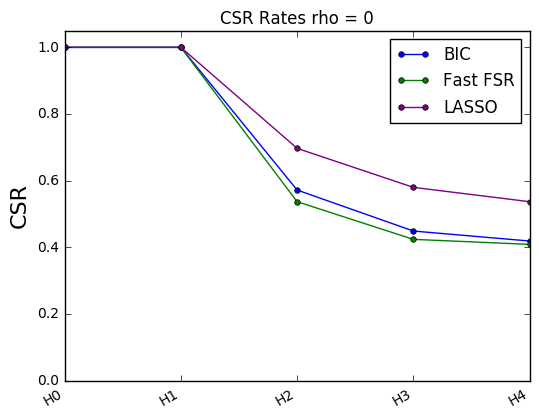

In [72]:
xlabel = [1, 2, 3, 4, 5]
xlabel_name = ['H0', 'H1', 'H2', 'H3', 'H4']

fig, ax = plt.subplots(figsize = (6, 5)) 
fig.autofmt_xdate()
plt.plot(xlabel, res_bic1['csr'], marker = 'o', markersize = 4, 
         color = 'blue', linestyle = 'solid',
         label = 'BIC')

plt.plot(xlabel, res_fsr1['csr'], marker = 'o', markersize = 4, 
         color = 'green', linestyle = 'solid',
         label = 'Fast FSR')

plt.plot(xlabel, res_lasso1['csr'], marker = 'o', markersize = 4, 
         color = 'purple', linestyle = 'solid',
         label = 'LASSO')

plt.legend(loc='upper right')
ax.set_ylabel('CSR', fontsize = 16)
ax.set_title('CSR Rates rho = 0')
plt.xticks(xlabel, xlabel_name)
plt.ylim([0,1.05])
pass  

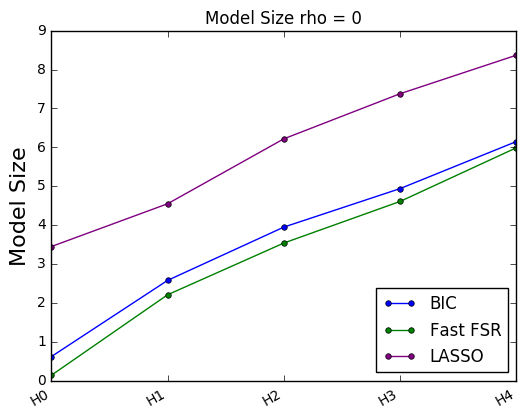

In [71]:
xlabel = [1, 2, 3, 4, 5]
xlabel_name = ['H0', 'H1', 'H2', 'H3', 'H4']

fig, ax = plt.subplots(figsize = (6, 5)) 
fig.autofmt_xdate()
plt.plot(xlabel, res_bic1['size'], marker = 'o', markersize = 4, 
         color = 'blue', linestyle = 'solid',
         label = 'BIC')

plt.plot(xlabel, res_fsr1['size'], marker = 'o', markersize = 4, 
         color = 'green', linestyle = 'solid',
         label = 'Fast FSR')

plt.plot(xlabel, res_lasso1['size'], marker = 'o', markersize = 4, 
         color = 'purple', linestyle = 'solid',
         label = 'LASSO')

plt.legend(loc='lower right')
ax.set_ylabel('Model Size', fontsize = 16)
ax.set_title('Model Size rho = 0')
plt.xticks(xlabel, xlabel_name)
pass 